In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.display import Image
from IPython.core.display import Image, display
import numpy as np

batch_size = 40
 
dataset = datasets.MNIST(root='./mnist_data/',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)

dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive/results/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [0]:
import zipfile
from PIL import Image
import torchvision.transforms.functional as TF

#my_image = Image.open('/gdrive/My Drive/2019Fall/train_images/1.jpg')
#print(my_image)
#my_x = TF.to_tensor(my_image)
#print(my_x.size())

archive = zipfile.ZipFile('/gdrive/My Drive/2019Fall/images.zip', 'r')

shoes_images = torch.tensor(np.empty([160, 3, 136, 136])).type(torch.DoubleTensor)
print(shoes_images)
print(a.size())

for i in range(160):
  imgfile = archive.open(str(i+1) + '.jpg')
  imgfile = TF.to_tensor(Image.open(imgfile)).type(torch.DoubleTensor)
  shoes_images[i] = imgfile
  #print(imgfile.size())
  #print(imgfile[0][88])
  #break

print(shoes_images.size())

tensor([[[[4.9407e-324, 4.9407e-324, 4.9407e-324,  ..., 4.9407e-324,
           4.9407e-324, 4.9407e-324],
          [4.9407e-324, 4.9407e-324, 4.9407e-324,  ..., 4.9407e-324,
           4.9407e-324, 4.9407e-324],
          [4.9407e-324, 4.9407e-324, 4.9407e-324,  ..., 4.9407e-324,
           4.9407e-324, 4.9407e-324],
          ...,
          [4.9407e-324, 4.9407e-324, 4.9407e-324,  ..., 4.9407e-324,
           4.9407e-324, 4.9407e-324],
          [4.9407e-324, 4.9407e-324, 4.9407e-324,  ..., 4.9407e-324,
           4.9407e-324, 4.9407e-324],
          [4.9407e-324, 4.9407e-324, 4.9407e-324,  ..., 4.9407e-324,
           4.9407e-324, 4.9407e-324]],

         [[4.9407e-324, 4.9407e-324, 4.9407e-324,  ..., 4.9407e-324,
           4.9407e-324, 4.9407e-324],
          [4.9407e-324, 4.9407e-324, 4.9407e-324,  ..., 4.9407e-324,
           4.9407e-324, 4.9407e-324],
          [4.9407e-324, 4.9407e-324, 4.9407e-324,  ..., 4.9407e-324,
           4.9407e-324, 4.9407e-324],
          ...,
     

In [0]:
shoes_dataloader = torch.utils.data.DataLoader(dataset=shoes_images,
                                              batch_size=batch_size,
                                              shuffle=False)

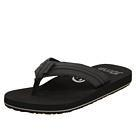

In [0]:
from IPython.display import Image
from IPython.core.display import Image, display

fixed_x = next(iter(shoes_dataloader))
recon_test_data = fixed_x[0]

# channels is 3 (R, G, B)
image_channels = fixed_x.size(1)
save_image(recon_test_data, 'temp.jpg')
Image('temp.jpg')

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 40, 6, 6)

In [0]:
class VAE(nn.Module):
    def __init__(self, image_channels, h_dim=36*40, z_dim=100):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 6, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(6, 12, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 30, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Conv2d(30, 40, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten()
            # 1440
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
             UnFlatten(),
             nn.ConvTranspose2d(40, 30, kernel_size=3, stride=2),
             nn.ReLU(),
             nn.ConvTranspose2d(30, 24, kernel_size=4, stride=1),
             nn.ReLU(), 
             nn.ConvTranspose2d(24, 12, kernel_size=3, stride=2),    
             nn.ReLU(), 
             nn.ConvTranspose2d(12, 6, kernel_size=3, stride=2),  
             nn.ReLU(), 
             nn.ConvTranspose2d(6, image_channels, kernel_size=4, stride=2),  
             nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [0]:
print(len(fixed_x))
model = VAE(image_channels=image_channels).type('torch.DoubleTensor').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

40


In [0]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_loss = 99999
ckpt_path = os.path.join(ckpt_dir, 'shoes_model.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    model.load_state_dict(ckpt['VAE_model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_loss = ckpt['best_loss']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best loss : %.2f' % best_loss)

In [0]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 55488), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [0]:
print(len(shoes_dataloader.dataset))

for batch_idx, data in enumerate(shoes_dataloader):
  print(batch_idx, data.size())

160
0 torch.Size([40, 3, 136, 136])
1 torch.Size([40, 3, 136, 136])
2 torch.Size([40, 3, 136, 136])
3 torch.Size([40, 3, 136, 136])


In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(shoes_dataloader):
        data = data.to(device).double()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data.double())
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(shoes_dataloader.dataset),
                100. * batch_idx / len(shoes_dataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))
    return train_loss

In [0]:
from IPython.core.display import Image, display

for epoch in range(1, 100000):
    train_loss = train(epoch)
    #test_loss = test(epoch)
    print(train_loss, best_loss)
    # save checkpoint whenever there is improvement in performance
    if train_loss < best_loss:
      best_loss = train_loss
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'VAE_model':model.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_loss':best_loss}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')
    if epoch % 1000 == 0 :
      with torch.no_grad():
          print("saving image..")
          a, b, c = model.forward(recon_test_data.view(1, 3, 136, 136))
          save_image(a[0], gdrive_root + 'recon_sample_' + str(epoch) + '.png')

          sample = torch.randn(16, 100).type('torch.DoubleTensor').to(device)
          sample = model.decode(sample).cpu()
          save_image(sample.view(16, 3, 136, 136),
                      gdrive_root + 'sample_' + str(epoch) + '.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 55488])) that is different to the input size (torch.Size([40, 3, 136, 136])) is deprecated. Please ensure they have the same size.
  


Train Epoch: 1 [0/160 (0%)]	Loss: 13834.498141
Train Epoch: 1 [40/160 (25%)]	Loss: 13406.815282
Train Epoch: 1 [80/160 (50%)]	Loss: 13730.583033
Train Epoch: 1 [120/160 (75%)]	Loss: 11962.292555
====> Epoch: 1 Average loss: 35.2895
2117367.5604217863 99999
Train Epoch: 2 [0/160 (0%)]	Loss: 13858.690434
Train Epoch: 2 [40/160 (25%)]	Loss: 13346.986709
Train Epoch: 2 [80/160 (50%)]	Loss: 13750.624623
Train Epoch: 2 [120/160 (75%)]	Loss: 11961.350122
====> Epoch: 2 Average loss: 35.2784
2116706.0755178854 99999
Train Epoch: 3 [0/160 (0%)]	Loss: 13783.033874
Train Epoch: 3 [40/160 (25%)]	Loss: 13319.398916
Train Epoch: 3 [80/160 (50%)]	Loss: 13702.213849
Train Epoch: 3 [120/160 (75%)]	Loss: 11986.217984
====> Epoch: 3 Average loss: 35.1939
2111634.5849065725 99999
Train Epoch: 4 [0/160 (0%)]	Loss: 13737.633395
Train Epoch: 4 [40/160 (25%)]	Loss: 13359.892342
Train Epoch: 4 [80/160 (50%)]	Loss: 13679.487413
Train Epoch: 4 [120/160 (75%)]	Loss: 11954.278284
====> Epoch: 4 Average loss: 35.15

KeyboardInterrupt: ignored

In [0]:
#print(dataset[0])
import pandas as pd

print(len(dataset))
print(len(dataset[0][0][0]))
#print(dataset[0][0][0].tolist())

latent_vector = []

for i, data in enumerate(shoes_dataloader):
  data = data.to(device)
  z, _, _ = model.type('torch.DoubleTensor').encode(data)
  latent_vector += z.tolist()
  #if (i+1) % 5 == 0 :
  #  break

dataframe = pd.DataFrame(latent_vector)
dataframe.to_csv(gdrive_root + '/data.csv', header = False, index = False)
print(latent_vector)
print(len(latent_vector))
print(len(latent_vector[0]))
# index, channel, 가로, 세로

60000
28
[[1.3005238658770846, -0.6607403812263882, 0.22326303063729583, 1.2894585798920752, 0.8525107564854447, -0.04913109734143839, 3.215961325827533, -1.4020363095709598, -0.9946277526489326, 0.22651475043426134, -0.4009238287245006, 0.4109803793273049, 0.6447844079528493, 0.8462539405008433, -1.2471637342458572, -1.0190412535744453, -0.33687087054843606, -1.2722112354209307, -0.32864149158569606, 2.2357895494401134, -0.4505676636803998, 1.0656569235881512, 0.261186880142115, 0.40507794401303576, -1.8351335305333882, 1.5110014745976519, 0.49189734716961453, -0.4413087019101821, 0.026888880066426646, -1.2435957992807134, 0.7767222477837556, 1.1087823366397052, 1.8623948867225728, 0.47857030521349564, -0.2153892002432567, -0.17415589926783517, 0.20168806083308577, -0.0511478921966535, 0.8753150155390506, 0.16791312410669537, 0.748487594559193, 0.07827163903721335, 0.07407814123424723, -1.801562184211122, -0.6021291377941482, -0.9513227740168249, 2.82739135779722, 0.6514921772789131, 

In [0]:
a = [[ 0 for _ in range(160)] for _ in range(160)]

for i in range(len(latent_vector)):
  for j in range(len(latent_vector)):
    a[i][j] = np.linalg.norm(np.asarray(latent_vector[i])-np.asarray(latent_vector[j]))
    if i == j :
      a[i][j] = 100

for i in range(len(latent_vector)):
  print(i+1, np.argmin(np.asarray(a[i]))+1)

1 44
2 131
3 2
4 23
5 2
6 145
7 85
8 96
9 121
10 88
11 160
12 116
13 121
14 121
15 94
16 147
17 88
18 8
19 105
20 136
21 152
22 154
23 4
24 145
25 160
26 43
27 121
28 123
29 90
30 104
31 107
32 6
33 107
34 107
35 109
36 67
37 97
38 8
39 60
40 68
41 44
42 149
43 137
44 2
45 88
46 119
47 160
48 152
49 102
50 128
51 160
52 117
53 101
54 42
55 48
56 154
57 145
58 131
59 104
60 118
61 8
62 2
63 123
64 38
65 104
66 1
67 147
68 58
69 128
70 149
71 2
72 116
73 145
74 121
75 2
76 43
77 91
78 31
79 121
80 143
81 8
82 71
83 145
84 159
85 116
86 108
87 131
88 87
89 150
90 10
91 77
92 2
93 44
94 102
95 5
96 8
97 98
98 34
99 48
100 102
101 53
102 94
103 143
104 2
105 5
106 158
107 34
108 2
109 35
110 104
111 2
112 62
113 121
114 102
115 144
116 2
117 158
118 60
119 46
120 128
121 102
122 160
123 138
124 155
125 71
126 129
127 121
128 69
129 35
130 52
131 87
132 102
133 5
134 25
135 9
136 20
137 138
138 123
139 46
140 155
141 160
142 126
143 2
144 5
145 73
146 48
147 67
148 160
149 42
150 89
151 2
15